# Homework 1 (Total Points: 175)



Learning Goals:
- Learn how to load a dataset and process it.
- Learn how to implement several IR methods (TFIDF, BM25, QL) and understand their weaknesses & strengths.
- Learn how to evaluate IR methods


**NOTE 1**: Only the code (`TODO: Implement this!` denotes these sections) is graded. The 'theory' questions in this assignment serve as a preparation for the exam and to facilitate a deeper understanding of the course content. These questions (denoted by `TODO: Answer this!`) have no points assigned to them, but **need** to be filled out before submission.  

**NOTE 2**: You can use the `nltk`, `numpy` and `matplotlib` libraries here. Other libraries, e.g., `gensim` or `scikit-learn`, may not be used. 

**NOTE 3**: The notebook you submit has to have the student ids, seperated by underscores (E.g., `12341234_12341234_12341234.ipynb`). 

**NOTE 4**: Make sure to check that your notebook runs before submission. A quick way to do this is to restart the kernel and run all the cells.  

---
Additional Resources: 
-  Sections 2.3, 4.1, 4.2, 4.3, 5.3, 5.6, 5.7, 6.2, 7, 8 of [Search Engines: Information Retrieval in Practice](https://ciir.cs.umass.edu/downloads/SEIRiP.pdf)


In [1]:
# imports 
# TODO: Ensure that no additional library is imported in the notebook. 
# TODO: Only the standard library and the following libraries are allowed:

import os
import zipfile
from functools import partial

import nltk
import requests
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.html import widgets
from collections import namedtuple

%matplotlib inline

/usr/lib/python3/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Section 1: Text Processing (20 points)

In this section, we will load the dataset and learn how to clean up the data to make it usable for an IR system. 

We are using the [CACM dataset](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/), which is a small, classic IR dataset, composed of a collection of titles and abstracts from the journal CACM. It comes with relevance judgements for queries, so we can evaluate our IR system. 

The following cell downloads the dataset and unzips it to a local directory

In [2]:
def download_dataset(folder_path = "./datasets/"):
    
    os.makedirs(folder_path, exist_ok=True)
    
    file_location = os.path.join(folder_path, "cacm.zip")
    
    # download file if it doesn't exist
    if not os.path.exists(file_location):
        
        url = "https://surfdrive.surf.nl/files/index.php/s/M0FGJpX2p8wDwxR/download"

        with open(file_location, "wb") as handle:
            print(f"Downloading file from {url} to {file_location}")
            response = requests.get(url, stream=True)
            for data in tqdm(response.iter_content()):
                handle.write(data)
            print("Finished downloading file")
    
    if not os.path.exists(os.path.join(folder_path, "train.txt")):
        
        # unzip file
        with zipfile.ZipFile(file_location, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
download_dataset()

You can see a brief description of each file in the dataset by looking at the README file

In [3]:
##### Read the README file 
!cat ./datasets/README
#####

Files in this directory with sizes:
          0 Jun 19 21:01 README

    2187734 Jun 19 20:55 cacm.all              text of documents
        626 Jun 19 20:58 cite.info             key to citation info
                                                (the X sections in cacm.all)
       2668 Jun 19 20:55 common_words           stop words used by smart
       2194 Jun 19 20:55 make_coll*             shell script to make collection
       1557 Jun 19 20:55 make_coll_term*        ditto (both useless without
                                                smart system)
       9948 Jun 19 20:55 qrels.text             relation giving
                                                    qid did 0 0
                                                to indicate dument did is
                                                relevant to query qid
      13689 Jun 19 20:55 query.text             Original text of the query


----
We are interested in 4 files:
- `cacm.all` : Contains the text for all documents. Note that some documents do not have abstracts available. 
- `query.text` : The text of all queries
- `qrels.text` : The relevance judgements
- `common_words` : A list of common words. This may be used as a collection of stopwords

In [4]:
##### The first 45 lines of the CACM dataset forms the first record
# We are interested only in 3 fields. 
# 1. the '.I' field, which is the document id
# 2. the '.T' field (the title) and
# 3. the '.W' field (the abstract, which may be absent)
!head -45 ./datasets/cacm.all
#####

.I 1
.T
Preliminary Report-International Algebraic Language
.B
CACM December, 1958
.A
Perlis, A. J.
Samelson,K.
.N
CA581203 JB March 22, 1978  8:28 PM
.X
100	5	1
123	5	1
164	5	1
1	5	1
1	5	1
1	5	1
205	5	1
210	5	1
214	5	1
1982	5	1
398	5	1
642	5	1
669	5	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
165	6	1
196	6	1
196	6	1
1273	6	1
1883	6	1
324	6	1
43	6	1
53	6	1
91	6	1
410	6	1
3184	6	1


---

Now, write a function to read in the `cacm.all` file. Note that each document has a variable number of lines. The `.I` field denotes a new document

In [5]:
# TODO: Implement this! (4 points)
def read_cacm_docs(root_folder = "./datasets/"):
    """
        Reads in the CACM documents. The dataset is assumed to be in the folder "./datasets/cacm" be default
        Returns: A list of 2-tuples: (doc_id, document), where 'document' is a single string created by 
            appending the title and abstract (seperated by a "\n"). 
            In case the record doesn't have an abstract, the document is composed only by the title
    """
    f = open(root_folder + "cacm.all", "r")

    # Dummy val for first abstract
    lijst = []
    abstract = ""

    # Split the line that's read
    split = f.readline().split()

    # Iterate over all entries in the ca
    for i in range(100000):

        # Append all current data if we encounter a .i again
        #print(split)
        if split[0] == ".I":
            if split[1] != str(1):
                lijst.append((int(doc_id), t + "" + abstract))
                t = ""
                abstract = ""

        # Check for index
        if split[0] == ".I":
            doc_id = split[1]

        # Check for Title
        if split[0] == ".T":
            t = f.readline()

        # Check for abstract
        if split[0] == ".W":

            w = f.readline()
            abstract = ""

            while w.split()[0] != ".B":
                abstract += w + " "
                w = f.readline()
            #print(abstract)

        # Split the line that's read
        split = f.readline().split()
        
        # Break if we reach EOF
        if not split:
            break 

    lijst.append((int(doc_id), t + "" + abstract))

    return lijst

docs = read_cacm_docs()

In [6]:
##### 
print(len(docs))
assert len(docs) == 3204, "There should be exactly 3024 documents"
##### 

3204


---

Next, let us read the queries. They are formatted similarly: 

In [7]:
##### The first 15 lines of 'query.text' has 2 queries
# We are interested only in 2 fields. 
# 1. the '.I' - the query id
# 2. the '.W' - the query
# 3. the '.W' field (the abstract, which may be absent)
!head -15 ./datasets/query.text
#####

.I 1
.W
 What articles exist which deal with TSS (Time Sharing System), an
operating system for IBM computers?
.N
 1. Richard Alexander, Comp Serv, Langmuir Lab (TSS)
 
.I 2
.W
 I am interested in articles written either by Prieve or Udo Pooch
.A
Prieve, B.
Pooch, U.
.N
 2. Richard Alexander, Comp Serv, Langmuir Lab (author = Pooch or Prieve)


---

Now, write a function to read in this file:

In [8]:
# TODO: Implement this! (3 points)
def read_queries(root_folder = "./datasets/"):
    """
        Reads in the CACM queries. The dataset is assumed to be in the folder "./datasets/" be default
        Returns: A list of 2-tuples: (query_id, query)
    """
    f = open(root_folder + "query.text", "r")

    # Dummy val for first abstract
    lijst = []
    query = ""

    # Split the line that's read
    split = f.readline().split()

    # Iterate over all entries in the ca
    for i in range(100000):

        # Append all current data if we encounter a .i again
        #print(split)
        if split[0] == ".I":
            if split[1] != str(1):
                lijst.append((doc_id, query))
                query = ""

        # Check for index
        if split[0] == ".I":
            doc_id = split[1]

        # Check for abstract
        if split[0] == ".W":

            w = f.readline()
            query = ""
            
            # Add all constituents of the query
            while w.split()[0] != ".N" and w.split()[0] != ".A":
                query += w + " "
                w = f.readline()

        # Split the line that's read
        split = f.readline().split()
        
        # Break if we reach EOF
        # Having a counter to prevent infinite loop
        count = 0
        
        while not split:
            split = f.readline().split()
            count += 1
            
            if count > 10:
                lijst.append((doc_id, query))
                return lijst

    #lijst.append((doc_id, query))

    return lijst

queries = read_queries()

In [9]:
##### 
print(len(queries))
assert len(queries) == 64 and all([q[1] is not None for q in queries]), "There should be exactly 64 queries"
##### 

64


---

Read in the stop words:

In [10]:
!head ./datasets/common_words

a
about
above
accordingly
across
after
afterwards
again
against
all


In [11]:
# TODO: Implement this! (3 points)
def load_stopwords(root_folder = "./datasets/"):
    """
    Load the stopwords
    Output: A set of stopwords
    """
    # Initialize set and open file
    stop_words = set()
    f = open(root_folder + "common_words", "r")
    
    for i in range(500):
        words = f.readline().split()
        
        # Exit loop if we encounter empty string - EOF
        if not words:
            break
        stop_words.add(words[0])

    # Gimme dem stopwords
    return stop_words
            
stopwords = load_stopwords()
assert len(stopwords) == 428

--- 

We can now write some basic text processing functions. A first step is to tokenize the text. You may use any tokenizer available in the `nltk` library:

In [12]:
# TODO: Implement this! (5 points)
def tokenize(text):
    """
        Tokenize the text. 
        Input: text - a string
        Output: a list of tokens
        
    """
    return nltk.word_tokenize(text)

In [13]:
#####
text = "the quick brown fox jumps over the lazy dog"
tokens = tokenize(text)
print(tokens)
#####

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


---

*Answer the following questions*: 
- Why is stemming necessary, in particular for IR?
    - Stemming is necessary because we want to be able to retrieve information based on a query as well as we possibly can. By 
      representing each word by its corresponding stem, we can ensure that we find all relevant documents related to the term
      instead of potentially excluding a lot of terms that only have an affix appended to the word. E.g. let's say someone
      searches for "cats" then "cat" will most likely result in relevancy too.
- Is there any setting (domain, scenario, etc) in which stemming can hurt performance? Illustrate with an example
    - Stemming can be aggressive, conservative or abscent altogether. By using stemming we increase the likelyhood that words in a query will match with words in a document. This however can prove to be counterproductive when the use of stemming results in too many matches that don't necessarily provide the information requested by the query e.g. user searches the word "flying" but is given information about different types of flies such as bees and houseflies, when the information the user was really requesting was in regards to air travel but stemming caused the word "flying" to be converted to "fly".

Write a function to stem tokens. Again, you can use the `nltk` library for this

In [14]:
# TODO: Implement this! (5 points)
def stem_token(token):
    """
        Stem the given token, using any stemmer available from the nltk library
        Input: a single token
        Output: the stem of the token
    """
    stemmer = nltk.PorterStemmer()
    return stemmer.stem(token)

In [15]:
####
print([stem_token(t) for t in tokens])
tokens_ = [
    'caresses', 'flies', 'dies', 'mules', 'denied',
    'died', 'agreed', 'owned', 'humbled', 'sized',
    'meeting', 'stating', 'siezing', 'itemization',
    'sensational', 'traditional', 'reference', 'colonizer',
    'plotted']
print([stem_token(t) for t in tokens_])
####

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog']
['caress', 'fli', 'die', 'mule', 'deni', 'die', 'agre', 'own', 'humbl', 'size', 'meet', 'state', 'siez', 'item', 'sensat', 'tradit', 'refer', 'colon', 'plot']


---

*Answer the following questions*: 
- Another processing step (not done here) is to use n-grams. Illustrate why you would want to use n-grams in IR with an example.  
    - *N-grams can be useful on both word level and character level. Word level N-grams can be used to reduce misspelled characters in words and thus reduce the amount of noise in text that might be difficult to match a query with. N-grams can also be used to model language, the more frequently a word n-gram occurs, the more likely it is to correspond to a meaningful phrase in the language.*
- Usage of n-grams exacerbates some problems ex. in bi-gram language models. What is this problem? Suggest one solution 
    - A common problem with n-gram models is the decreased occurence of higher order n-grams as opposed to lower order n-grams. Very specific higher order n-grams will very infrequently occur in different documents, causing the probabilities to go down for almost every document for this specific n-gram. A potential solution would be using different subsets of the higher order n-grams to see which combinations give us the best results to our query.

--- 

The following function puts it all together. Given a string, it tokenizes it, and processes it according to the flags that you set.

In [16]:
#### Putting it all together
def process_text(text, stem=False, remove_stopwords=False, lowercase_text=False):
    
    tokens = []
    for token in tokenize(text):
        if remove_stopwords and token.lower() in stopwords:
            continue
        if stem:
            token = stem_token(token)
        if lowercase_text:
            token = token.lower()
        tokens.append(token)

    return tokens
#### 

Let's create two sets of pre-processed documents

In [17]:
# In this configuration:
# Don't preprocess the text, except to tokenize 
config_1 = {
  "stem": False,
  "remove_stopwords" : False,
  "lowercase_text": True
} 


# In this configuration:
# Preprocess the text: stem and remove stopwords
config_2 = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True, 
} 


We can now process the documents and queries according to the configuration specified above

In [18]:
####
doc_repr_1 = []
doc_repr_2 = []
for (doc_id, document) in docs:
    doc_repr_1.append((doc_id, process_text(document, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, **config_2)))

####

In [19]:
doc_repr_1[0]

(1, ['preliminary', 'report-international', 'algebraic', 'language'])

In [20]:
doc_repr_2[0]

(1, ['preliminari', 'report-intern', 'algebra', 'languag'])


--- 

## Section 2: Indexing (10 points)


A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


### Building an index

A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


---

In this assignment we will be using an index created in memory, since our dataset is tiny. To get started, build a simple index that maps simply counts the number of tokens present in a document. This index  is built using a python dictionary.

*Answer the following questions*:
- What is the time complexity of retrieving a list of documents from a python `dict` object? 
    - A simple dictionary where each list of documents is behind a given key value would require an operation consisting of O(1) time complexity.
- Consider the case with a 10 million documents. What is the time complexity of retrieval with an inverted index (assuming you can fit the entire index in memory)? (Hint: Consider length of a query $|q|$) 
    - If our query is an index term that can be used in it's entirety as a key for our python dictionary, then the time complexity will be O(1). This however is often infeasible for every possible query so we might have to use every individual word in our query to retrieve the corresponding documents, this will have a time complexity of O(n) where n corresponds to the length of our query.
- For a large enough collection, we cannot store an index in memory. How is this tackled in practice (briefly explain)? Comment on the time complexity. 
    - Two potential solutions may exist. The first one would be to use a database instead which potentially slows down the time complexity because we can not use our O(1) look-ups in dictionaries anymore. The second way to tackle this problem is by going through the collection every single time, 'implicitly' building the index, keeping track of counts but not saving the results in an index. This would increase our time complexity very significantly because we would have to build the implicit index each time.
- Mention a use-case in which a simple index (from word -> doc_id) might not suffice anymore. How would you modify the index to suit this use-case (if you can!)  
    - If the amount of documents is so large that it becomes infeasible to go through the entire list of documents at each word entry in the index, we could change these lists to dictionaries allowing us to have faster look-ups for specific documents in each entry.
    
    
Now, implement a function to build an index:

In [21]:
# doc_repr_1 is NOT stemmed etc
# doc_repr_2 is tokenized and stemmed etc

In [22]:
# TODO: Implement this! 10 points
def build_tf_index(documents):
    """
    Build an inverted index (with counts). The output is a dictionary which takes in a token
    and returns a list of (doc_id, count) where 'count' is the count of the 'token' in 'doc_id'
    Input: a list of documents - (doc_id, tokens) 
    Output: An inverted index. [token] -> [(doc_id, token_count)]
    """
    # Initialize the main dictionary
    # And a value dictionary to reduce computational complexity
    indexdict = {}
    
    # Naive implementation because I didn't manage to quickly write a faster implementation
    for i in range(len(documents)):
        valuedict = {}
        
        # Get doc_id and content
        doc_id, content = documents[i]
        doc_id = int(doc_id)        

        # Initialize all values to 0
        for word in content:
            valuedict[word] = 0
        
        # Do actual counting
        for word in content:
            valuedict[word] += 1
            
        for key, value in valuedict.items():
            
            # Is this a set lookup? guess not
            if key in indexdict.keys():
                indexdict[key].append((doc_id, value))
            else:
                indexdict[key] = [(doc_id, value)]
        
    return indexdict
        
 
# Create the 2 indices
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)

#test_index = build_tf_index([(1, ["hoi", "hoi", "poep", "hoi", "poep"]), (2,["hey", "hoi", "hoi", "hey"])])

# This function returns the correct index 
def get_index(index_set):
    assert index_set in {1, 2}
    return {
        1: tf_index_1,
        2: tf_index_2
    }[index_set]

# This function correctly pre-processes the text given the index set
def preprocess_query(text, index_set):
    assert index_set in {1, 2}
    if index_set == 1:
        return process_text(text, **config_1)
    elif index_set == 2:
        return process_text(text, **config_2)


--- 

## Section 3: Retrieval  (80 points)

Now that we have cleaned and processed our dataset, we can start building simple IR systems. 

For now, we consider *simple* IR systems, which involve computing scores from the tokens present in the document/query. More advanced methods are covered in later assignments.

We will implement the following methods in this section:
- TF-IDF
- BM25
- Query Likelihood Models

--- 

### Ranking functions


Probably the simplest IR model is the Bag of Words (BOW) model. Implement a function that scores a query against a document using this model.   

Note that you can use either the count of the token or 'binarize' it i.e set the value equal to 1 if the token appears.   


**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

In [23]:
# TODO: Implement this! 10 points
def dict_to_sorted_list(dictionary):
    output = []
    dictionary = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse=True)}
    for key, val in dictionary.items():
        output.append((key,val))
    return output
    
def bow_search(query, index_set):
    """
        Perform a search over all documents with the given query. 
        Note #1: You have to use the `get_index` function created in the previous cells
        Note #2: You can binarize the counts if you wish to
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    query = preprocess_query(query, index_set)
    
    valuecount = {}
    
    
    for word in query:
        if(word not in index):
            continue
        lijst = index[word]
        
        for (a,b) in lijst:
            if not a in valuecount:
                valuecount[a] = 1.0
            else:
                valuecount[a] += 1.0
        
    return dict_to_sorted_list(valuecount)

In [24]:
query = "propose equivalent glossary simple"
ding = bow_search(query,2)

*Answer the following questions*: 
- The BOW model is might not be a good choice for use in IR. Why? 
    - *Bag of words is a useful method for retrieval and classification but it has its downsides. BoW does not give a good representation of a document because of the independence assumption, this results in different documents having the same representation, even though the two documents share the same words and score. The main challenge that the BoW representation faces is that word order can have a significant impact on what information is presented in the document which is not captured by the model.*

In [25]:
####
docs_by_id = dict(docs)
def print_results(docs, len_limit=50):    
    for i, (doc_id, score) in enumerate(docs):
        doc_content = docs_by_id[doc_id].strip().replace("\n", "\\n")[:len_limit] + "..."
        print(f"Rank {i}({score:.2}): {doc_content}")

test_bow = bow_search("report", index_set=1)[:5]
print(f"BOW Results:")
print_results(test_bow)
#### 

BOW Results:
Rank 0(1.0): ALGOL Sub-Committee Report - Extensions...
Rank 1(1.0): The Use of Computers in Engineering Classroom Inst...
Rank 2(1.0): Report on a Conference of University Computing Cen...
Rank 3(1.0): Report on the Algorithmic Language ALGOL 60...
Rank 4(1.0): SMALGOL-61\nPrior to and during the 1961 Western J...


Before we implement the tf-idf scoring functions, let's first write a function to compute the document frequencies of all words.  

In [26]:
# TODO: Implement this! (5 points)
def compute_df(documents):
    """
        Compute the document frequency of all terms in the vocabulary
        Input: A list of documents
        Output: A dictionary with {token: document frequency)
    """
    N = len(documents)
    output = {}
    for doc in documents:
        doc = set(doc)
        for word in doc:
            if not word in output:
                output[word] = 1
            else:
                output[word] += 1
                
    for key, val in output.items():
        output[key] = val/N
        
    return output


# get the document frequencies of each document
df_1 = compute_df([d[1] for d in doc_repr_1])
df_2 = compute_df([d[1] for d in doc_repr_2])

def get_df(index_set):
    assert index_set in {1, 2}
    return {
        1: df_1,
        2: df_2
    }[index_set]

Next, implement a function that computes a tf-idf score given a query.      

In [27]:
# TODO: Implement this! 10 points
def tfidf_search(query, index_set):
    """
        Perform a search over all documents with the given query using tf-idf. 
        Note #1: You have to use the `get_index` (and the `get_df`) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    query = preprocess_query(query, index_set)
    df = get_df(index_set)
    tfidfcount = {}
    
    for q in query:
        if(q not in index):
            continue
        for doc, count in index[q]:
            tfidf = np.log(1 +count) * np.log(1/df[q])
            if not doc in tfidfcount:
                tfidfcount[doc] = tfidf
            else:
                tfidfcount[doc] += tfidf
                
    return dict_to_sorted_list(tfidfcount)

In [28]:
####
test_tfidf = tfidf_search("report", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_tfidf)
####

TFIDF Results:
Rank 0(7.7): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(7.1): An Information Algebra - Phase I Report-Language\n...
Rank 2(5.5): ALGOL 60 Confidential\nThe ALGOL 60 Report,* when ...
Rank 3(4.4): Automatic Abstracting and Indexing Survey and Reco...
Rank 4(4.4): A String Language for Symbol Manipulation Based on...


*Answer the following questions*: 
- It is generally not advisable to use the naive version of tf-idf. Why?
    - Naive tf-idf also utilizes the naive bayes assumption. This will simplify a lot of the mathematics involved but will not reflect the reality that words do not occur independently in text. This will result in individual words being more important than phrases and semantics which is likely to result in worse results.
- Illustrate with an example why using a sublinear scaling for TF is preferable in some cases.  
    - Using sublinear scaling helps mitigate the effect that will cause our model to assign more weight to documents that have a high frequency of a given word than it should. Just because the word "football" occurs 20 times more in a document, does not neccecarily mean that the document has 20 times more significance than other documents that contain the word "football".

--- 

*Answer the following questions*: 
- An alternative way to compute a query<>document score is to vectorize both the query and document (where each dimension corresponds to a token), and compute a score. The score can be computed using a dot product between the query and the document vectors. Why is the cosine similary function a better choice, particularly in IR? 
    - The vectorized representation of a query and a document is likely to vary a lot in terms of length. By computing the cosine similarity, we normalize the vector representations and only factor in difference in terms or orientation. Documents that share a high cosine similarity score with a query are likely to be relevant to the search.
- What is the time complexity of a search if we are using the vector space method mentioned in the previous question? What is the time complexity if we're using an index (assume that it fits in memory)? Assume $N$ is the number of documents and $|q|$ is the length of a query. 
    - To calculate the cosine similarity we need to calculate the dot product and the magnitudes of the vectors which can be done with one iterator over |V| where V is the size of the vocabulary such the complexity of that part will be O(|V|) and we have to do this for each document giving us a complexity of O(N $\times$ |V|). If we're using an index, this complexity is of O(N $\times$ |q|) because for each word in the query we have to retrieve the list of (N/average # of elements for each word in the index) and do something with the list.

--- 

#### Query Likelihood Models

In this section you will implement a simple query likelihood model. 

First, let use implement a naive version of a QL model, assuming a multinomial unigram language model (with a uniform prior over the documents). 

**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

--- 

*Answer the following questions*: 
- Write down the formula for computing the query likelihood, assuming a multinomial unigram language model. 
    - $P(Q|D) = \prod_{i = 1}^n P(q_i|D)$ where $q_i$ is a query word and there are n words in the query and $P(q_i|D) = \frac{f_{qi},D}{|D|}$ where $f_{qi},D$ is the number of times word qi occurs in document D. 
- What problem does this naive method have? Suggest a simple way to fix it.
    - For some documents if a specific word in the query does not appear in that document, its total score goes to 0 because of the multiplication even though the other words may occur very frequently making the document likely to be relevant. This can be offset by using smoothing, so the absence of certain words doesn't completely make the probability go to 0.

In [29]:
####
def doc_lengths(documents):
    doc_lengths = {doc_id:len(doc) for (doc_id, doc) in documents}
    return doc_lengths

doc_lengths_1 = doc_lengths(doc_repr_1)
doc_lengths_2 = doc_lengths(doc_repr_2)

def get_doc_lengths(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_lengths_1,
        2: doc_lengths_2
    }[index_set]
####

In [30]:
# TODO: Implement this! 15 points
def naive_ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a naive QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    query = preprocess_query(query, index_set)
    lens = get_doc_lengths(index_set)
    dictje = {}
    
    for doc in set([d for _, val in index.items() for d,unk in val]):
        dictje[doc] = 0.0
    
    for q in query:
        if(q not in index):
            continue
        seen = {}
        for doc, count in index[q]:
            if dictje[doc] == -float('inf'):
                continue
            if(doc in dictje):
                dictje[doc] += np.log(count) - np.log(lens[doc])
            else:
                dictje[doc] = np.log(count) - np.log(lens[doc])
            seen[doc] = 0
        for doc in dictje.keys():
            if(doc not in seen):
                dictje[doc] += -float('inf')
    
    return dict_to_sorted_list(dictje)

In [31]:
####
test_naiveql = naive_ql_search("report", index_set=1)[:5]
print(f"NaiveQL Results:")
print_results(test_naiveql)
####

NaiveQL Results:
Rank 0(-1.6): ALGOL Sub-Committee Report - Extensions...
Rank 1(-1.6): A Report Writer For COBOL...
Rank 2(-1.6): A CRT Report Generating System...
Rank 3(-1.8): Supplement to the ALGOL 60 Report...
Rank 4(-1.9): Report on the Algorithmic Language ALGOL 60...


Now, let's implement a (slightly more) complex QL model. This model should 'fix' the issue with the previous method. If your model requires hyperparameters, set a reasonable value. 

In [32]:
# TODO: Implement this! 20 points
def ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a naive QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    query = preprocess_query(query, index_set)
    lens = get_doc_lengths(index_set)
    dictje = {}
    
    for doc in set([d for _, val in index.items() for d,unk in val]):
        dictje[doc] = 0.0
        
    eps = -5
    
    for q in query:
        if(q not in index):
            continue
        seen = set()
        for doc, count in index[q]:
            if dictje[doc] == -float('inf'):
                continue
            if(doc in dictje):
                dictje[doc] += np.log(count) - np.log(lens[doc])
            else:
                dictje[doc] = np.log(count) - np.log(lens[doc])
            seen.add(doc)
        for doc in dictje.keys():
            if(doc not in seen):
                dictje[doc] += eps
    
    return dict_to_sorted_list(dictje)

In [33]:
#### Test the QL model
test_ql_results = ql_search("report", index_set=1)[:5]
print_results(test_ql_results)
print()
test_ql_results_long = ql_search("report " * 10, index_set=1)[:5]
print_results(test_ql_results_long)
####

Rank 0(-1.6): ALGOL Sub-Committee Report - Extensions...
Rank 1(-1.6): A Report Writer For COBOL...
Rank 2(-1.6): A CRT Report Generating System...
Rank 3(-1.8): Supplement to the ALGOL 60 Report...
Rank 4(-1.9): Report on the Algorithmic Language ALGOL 60...

Rank 0(-1.6e+01): ALGOL Sub-Committee Report - Extensions...
Rank 1(-1.6e+01): A Report Writer For COBOL...
Rank 2(-1.6e+01): A CRT Report Generating System...
Rank 3(-1.8e+01): Supplement to the ALGOL 60 Report...
Rank 4(-1.9e+01): Report on the Algorithmic Language ALGOL 60...


*Answer the following questions*: 
- What happens to the query likelihood for long queries? What is a simple fix for this issue?
    - Either its values can get really low due to smoothing or its score changes more than we want based on the repeated occurrence of a single word. The latter can be fixed by disregarding subsequent words in the query that are the same.


--- 

#### BM25

In this section, we will implement the widely used and hard to beat BM25 scoring function. 


In [34]:
# TODO: Implement this! (20 points)
def bm25_search(query, index_set,k1=1.5,k3=0,b=0.75):
    """
        Perform a search over all documents with the given query using BM25. 
        Note #1: You have to use the `get_index` (and `get_doc_lengths`) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a(n unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    query = preprocess_query(query, index_set)
    lens = get_doc_lengths(index_set)
    df = get_df(index_set)
    dictje = {}
    
    avglen = 0
    for key,val in lens.items():
        avglen += val
    avglen /= len(lens)
    
    for q in set(query):
        if(q not in index):
            continue
        for doc, count in index[q]:
            qcount = query.count(q)
            tfidf = (count * (k1+1) / (count + k1 * (1-b+b*lens[doc]/avglen))) * ((k3+1)*qcount)/(k3+qcount) * np.log(1/df[q])
            if not doc in dictje:
                dictje[doc] = tfidf
            else:
                dictje[doc] += tfidf
    
    return dict_to_sorted_list(dictje)

In [35]:
#### Test the BM25 model
test_bm25_results = bm25_search("report", index_set=1)[:5]
print_results(test_bm25_results)
####

Rank 0(6.8): ALGOL Sub-Committee Report - Extensions...
Rank 1(6.8): A Report Writer For COBOL...
Rank 2(6.8): A CRT Report Generating System...
Rank 3(6.7): Supplement to the ALGOL 60 Report...
Rank 4(6.6): Report on the Algorithmic Language ALGOL 60...




*Answer the following questions*: 
- Briefly explain how the BM25 model improves upon the tf-idf model.
    - The BM25 extends the scoring function by incorporationg a propabilistic approach and the inclusion of document and query term weight. This allows the queries and documents to be more directly comparible than using a standard term scoring method using the cosine similarity. 
    
---

In [36]:
#### Highlighter function
# class for results
ResultRow = namedtuple("ResultRow", ["doc_id", "snippet", "score"])
# doc_id -> doc
docs_by_id = dict((d[0], d[1]) for d in docs)

def highlight_text(document, query, tol=17):
    import re
    tokens = tokenize(query)
    regex = "|".join(f"(\\b{t}\\b)" for t in tokens)
    regex = re.compile(regex, flags=re.IGNORECASE)
    output = ""
    i = 0
    for m in regex.finditer(document):
        start_idx = max(0, m.start() - tol)
        end_idx = min(len(document), m.end() + tol)
        output += "".join(["...",
                        document[start_idx:m.start()],
                        "<strong>",
                        document[m.start():m.end()],
                        "</strong>",
                        document[m.end():end_idx],
                        "..."])
    return output.replace("\n", " ")


def make_results(query, search_fn, index_set):
    results = []
    for doc_id, score in search_fn(query, index_set):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results
####

---
---

The widget below allows you to play with the search functions you've written so far. This can be used, for example, to answer some of the theory questions

In [37]:
# Set this to the function you want to test
# this function should take in a query (string)
# and return a sorted list of (doc_id, score) 
# with the most relevant document in the first position
search_fn = bm25_search
index_set = 1

text = widgets.Text(description="Search Bar", width=200)
display(text)

def handle_submit(sender):
    print(f"Searching for: '{sender.value}'")
    
    results = make_results(sender.value, search_fn, index_set)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit)

## Section 4: Offline Evaluation (45 points)

Before we jump in and implement an algorithm for retrieval, we first have to learn how to evaluate such a system. In particular, we will work with offline evaluation metrics. These metrics are computed on a dataset with known relevance judgements.

Implement the following evaluation metrics. 

1. Precision
2. Recall
3. Mean Average Precision
4. Expected Reciprocal Rank

---
*Answer the following questions*: 
- What are the main limitations of an offline evaluation?
    - *The main problems with offline evaluation is that it can be difficult to build test collections that accurately reflect real users and traffic. The test set that is used for offline evaluation is more likely to be biased and the results will not portray how successful the search engine is for the end user as effectively as online evaluation. Online evaluation is able to more accuratly evaluate how effective the system is because it is being evaluated on metrics that portray the actual usage of the search engine in a real life scenario.*

---

Let's take a look at the `qrels.text` file, which contains the ground truth relevance scores. The relevance labels for CACM are binary - either 0 or 1. 


In [38]:
!head ./datasets/qrels.text

01 1410  0 0
01 1572  0 0
01 1605  0 0
01 2020  0 0
01 2358  0 0
02 2434  0 0
02 2863  0 0
02 3078  0 0
03 1134  0 0
03 1613  0 0


The first column is the `query_id` and the second column is the `document_id`. You can safely ignore the 3rd and 4th columns. Write a function to read in the file: 

In [39]:
# TODO: Implement this!
def read_qrels(root_folder = "./datasets/"):
    """
        Reads the qrels.text file. 
        Output: A dictionary: query_id -> [list of relevant documents]
    """
    
    # Read file
    with open(root_folder + 'qrels.text', 'r') as content_file:
        content = content_file.readlines()
    
    # Dictionary and initialize all values to empty list
    output = {}
    for line in content:
        split = line.split()
        query_id = split[0]
        output[query_id] = []
        
    # Add all relevant documents    
    for line in content:
        split = line.split()
        query_id = split[0]
        doc_id = split[1]

        output[query_id].append(doc_id)
    
    return output

qrels = read_qrels()

In [40]:
####
assert len(qrels) == 52, "There should be 52 queries with relevance judgements"
assert sum(len(j) for j in qrels.values()) == 796, "There should be a total of 796 Relevance Judgements"
####

Now, implement the metrics below. 

**Note:** For a given query `query_id`, you can assume that documents *not* in `qrels[query_id]` are not relevant to `query_id`. 


In [41]:
import math

# TODO: Implement this! (10 points)
def recall_k(results, relevant_docs, k):
    """
        Compute Recall@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Recall@K
    """
    output = 0
    for i in range(k):
        doc_id, _ = results[i]
        if str(doc_id) in relevant_docs:
            output += 1
            
    output /= len(relevant_docs)
    return output
    
# TODO: Implement this! (10 points)
def precision_k(results, relevant_docs, k):
    """
        Compute Precision@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), 
                    with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Precision@K
    """
    output = 0
    
    for i in range(k):
        doc_id, _ = results[i]
        if str(doc_id) in relevant_docs:
            output += 1
    
    output /= k
    return output
    

# TODO: Implement this! (10 points)
def average_precision(results, relevant_docs):
    """
        Compute Average Precision (for a single query - the results are 
        averaged across queries to get MAP in the next few cells)
        Hint: You can use the recall_k and precision_k functions here!
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: Average Precision
    """
    output = 0
    
    for i in range(len(results)):
        doc_id, _ = results[i]
        output += precision_k(results, relevant_docs, i+1) * (str(doc_id) in relevant_docs)
        
    output /= len(relevant_docs)
    return output


# TODO: Implement this! (15 points)
def err(results, relevant_docs):
    """
        Compute the expected reciprocal rank.
        Hint: https://dl.acm.org/doi/pdf/10.1145/1645953.1646033?download=true
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: ERR
        
    """
    p = 1
    err = 0
    maxscore = 0
    for doc_id, score in results:
        if(maxscore < score):
            maxscore = score
    
    for r in range(len(results)):
        doc_id, score = results[r]
        prob = score_to_prob(score, maxscore)
        err += p * prob / (r+1) # r+1 because pseudo-code starts with 1 instead of 0
        p *= (1-prob)
    return err
        
# This function should compute a probability out of our self-defined scores
def score_to_prob(score, maxscore):
    prob = (2**score - 1) / (2**maxscore)
    if(math.isnan(prob)):
        return not math.isnan(prob)
    return prob
####

*Answer the following questions*: 
- What are the main drawbacks of precision & recall?
    - Recall can only increase in this scenario because the denominator is always constant. Precision only tells us the fraction of true positives among the set of positive instances but doesn't take into account the extent to which they are relevant to the query. This is why we're usually interested in the combination of the two, such as the F-measure.
- What problems with Precision@K does Average Precision solve? 
    - Average Precision also takes the order in which the relevant documents are presented into account, discounting the score if we find documents later than we want.
- The CACM dataset has *binary* relevance judgements. However, a more suitable way of assigning judgements is to use graded relevance. Mention a metric which might be more suitable for a graded relevance, and breifly explain why. 
    - Discounted Cumulative Gain or Expected Reciprocal Rank. DCG is well suited for the task because it gives us a weighted result based on the order in which the relevant documents are presented to us, incorporating the same notion as Average Precision that retrieving relevant documents as soon as possible is preferred over finding them later.
- Consider a text processing step: stemming. What effect does this have on metrics? (Hint: Try changing the pre-processing config and try it out!)
    - Stemming causes most of our metrics to go up. This happens because many relevant documents may frequently use the word in a slightly different way or with an inflected form of the word. Disregarding these words because they're not exactly the same results in us having more trouble retrieving these particular documents. Stemming enables us to find the most relevant documents earlier on in the search process (e.g. improving Average Precision) and retrieving the relevant documents at all, improving precision and recall. 

---

Let's define some metrics@k using [partial functions](https://docs.python.org/3/library/functools.html#functools.partial)

In [42]:
####
recall_at_1 = partial(recall_k, k=1)
recall_at_5 = partial(recall_k, k=5)
recall_at_10 = partial(recall_k, k=10)
precision_at_1 = partial(precision_k, k=1)
precision_at_5 = partial(precision_k, k=5)
precision_at_10 = partial(precision_k, k=10)
####

---

The following function evaluates a `search_fn` using the `metric_fn`. Note that the final number is averaged over all the queries

In [43]:
####
def evaluate_search_fn(search_fn, metric_fn, index_set):
    # build a dict query_id -> query 
    queries_by_id = dict((q[0], q[1]) for q in queries)
    
    metrics = np.zeros(len(qrels), dtype=np.float32)
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        query = queries_by_id[str(int(query_id))]
        results = search_fn(query, index_set)
        metrics[i] = metric_fn(results, relevant_docs)
    
    return metrics.mean()
####

In [44]:
index_sets = {1, 2}

list_of_metrics = [
    ("ERR", err),
    ("MAP", average_precision),
    ("Recall@1",recall_at_1),
    ("Recall@5", recall_at_5),
    ("Recall@10", recall_at_10),
    ("Precision@1", precision_at_1),
    ("Precision@5", precision_at_5),
    ("Precision@10", precision_at_10)]

list_of_search_fns = [
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search),
    ("BOW", bow_search),
    ("TF-IDF", tfidf_search)
]


results = {}
for index_set in index_sets:
    results[index_set] = {}
    print(f"Index: {index_set}")
    for search_fn_name, search_fn in list_of_search_fns:
        print(f"\tEvaluating Search Function: {search_fn_name}")
        results[index_set][search_fn_name] = {}
        for metric_name, metric_fn in list_of_metrics:
            r = evaluate_search_fn(search_fn, metric_fn, index_set).mean()
            print(f"\t\tMetric: {metric_name}: {r}")
            results[index_set][search_fn_name][metric_name] = r
        print()

Index: 1
	Evaluating Search Function: NaiveQL


/usr/lib/python3/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in double_scalars


		Metric: ERR: -inf
		Metric: MAP: 0.008053875528275967
		Metric: Recall@1: 0.00332724885083735
		Metric: Recall@5: 0.006823752541095018
		Metric: Recall@10: 0.006823752541095018
		Metric: Precision@1: 0.057692307978868484
		Metric: Precision@5: 0.01923076994717121
		Metric: Precision@10: 0.009615384973585606

	Evaluating Search Function: QL
		Metric: ERR: -inf
		Metric: MAP: 0.03792444244027138
		Metric: Recall@1: 0.004772678483277559
		Metric: Recall@5: 0.035587139427661896
		Metric: Recall@10: 0.06285060197114944
		Metric: Precision@1: 0.09615384787321091
		Metric: Precision@5: 0.0615384615957737
		Metric: Precision@10: 0.05192307382822037

	Evaluating Search Function: BM25
		Metric: ERR: 0.999882161617279
		Metric: MAP: 0.20748016238212585
		Metric: Recall@1: 0.06861119717359543
		Metric: Recall@5: 0.17815765738487244
		Metric: Recall@10: 0.24638524651527405
		Metric: Precision@1: 0.48076921701431274
		Metric: Precision@5: 0.2730769217014313
		Metric: Precision@10: 0.21730770170688

## Section 5: Results and Analysis (20 points)

The `results` dictionary contains the results for all search functions we implemented. Plot the results in bar charts, with clear labels:

# Index 1

In [45]:
# TODO: Implement this! (20 points)
first_results = results[1]

err1 = [first_results[x]['ERR'] for i, x in enumerate(first_results)]
map1 = [first_results[x]['MAP'] for i, x in enumerate(first_results)]

recall1_1 = [first_results[x]['Recall@1'] for i, x in enumerate(first_results)]
recall1_5 = [first_results[x]['Recall@5'] for i, x in enumerate(first_results)]
recall1_10 = [first_results[x]['Recall@10'] for i, x in enumerate(first_results)]

precision1_1 = [first_results[x]['Precision@1'] for i, x in enumerate(first_results)]
precision1_5 = [first_results[x]['Precision@5'] for i, x in enumerate(first_results)]
precision1_10 = [first_results[x]['Precision@10'] for i, x in enumerate(first_results)]

In [46]:
barWidth = 0.25

r1 = np.arange(len(err1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]

### Recall

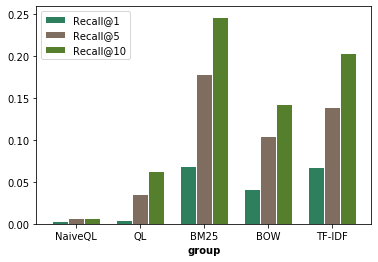

In [47]:
plt.bar(r3, recall1_1, color='#2d7f5e', width=barWidth, edgecolor='white', label='Recall@1')
plt.bar(r4, recall1_5, color='#7f6d5f', width=barWidth, edgecolor='white', label='Recall@5')
plt.bar(r5, recall1_10, color='#557f2d', width=barWidth, edgecolor='white', label='Recall@10')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + 0.75 for r in range(len(err1))], ['NaiveQL', 'QL', 'BM25', 'BOW', 'TF-IDF'])

plt.legend()
plt.show()

### Precision

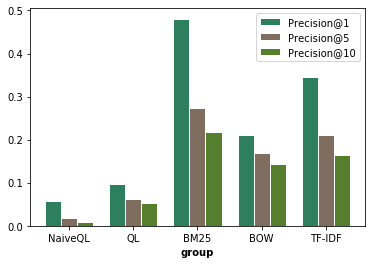

In [48]:
plt.bar(r6, precision1_1, color='#2d7f5e', width=barWidth, edgecolor='white', label='Precision@1')
plt.bar(r7, precision1_5, color='#7f6d5f', width=barWidth, edgecolor='white', label='Precision@5')
plt.bar(r8, precision1_10, color='#557f2d', width=barWidth, edgecolor='white', label='Precision@10')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + 1.5 for r in range(len(err1))], ['NaiveQL', 'QL', 'BM25', 'BOW', 'TF-IDF'])

plt.legend()
plt.show()

### Error

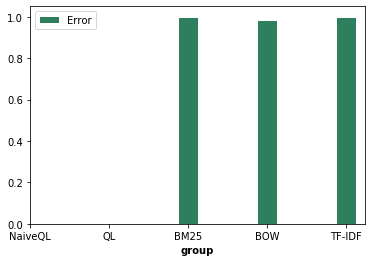

In [49]:
plt.bar(r2, err1, color='#2d7f5e', width=barWidth, edgecolor='white', label='Error')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(err1))], ['NaiveQL', 'QL', 'BM25', 'BOW', 'TF-IDF'])

plt.legend()
plt.show()

### MAP

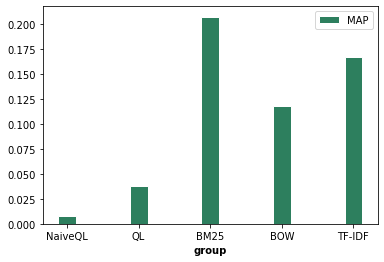

In [50]:
plt.bar(r2, map1, color='#2d7f5e', width=barWidth, edgecolor='white', label='MAP')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(err1))], ['NaiveQL', 'QL', 'BM25', 'BOW', 'TF-IDF'])

plt.legend()
plt.show()

# Index 2

In [51]:
# TODO: Implement this! (20 points)
second_results = results[2]

err1 = [first_results[x]['ERR'] for i, x in enumerate(first_results)]
map1 = [first_results[x]['MAP'] for i, x in enumerate(first_results)]

recall1_1 = [first_results[x]['Recall@1'] for i, x in enumerate(first_results)]
recall1_5 = [first_results[x]['Recall@5'] for i, x in enumerate(first_results)]
recall1_10 = [first_results[x]['Recall@10'] for i, x in enumerate(first_results)]

precision1_1 = [first_results[x]['Precision@1'] for i, x in enumerate(first_results)]
precision1_5 = [first_results[x]['Precision@5'] for i, x in enumerate(first_results)]
precision1_10 = [first_results[x]['Precision@10'] for i, x in enumerate(first_results)]

In [52]:
barWidth = 0.25

r1 = np.arange(len(err1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]

### Recall

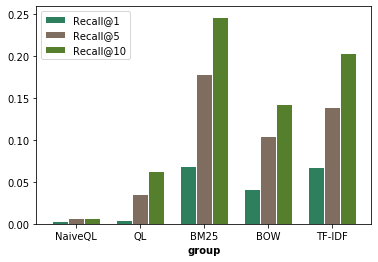

In [53]:
plt.bar(r3, recall1_1, color='#2d7f5e', width=barWidth, edgecolor='white', label='Recall@1')
plt.bar(r4, recall1_5, color='#7f6d5f', width=barWidth, edgecolor='white', label='Recall@5')
plt.bar(r5, recall1_10, color='#557f2d', width=barWidth, edgecolor='white', label='Recall@10')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + 0.75 for r in range(len(err1))], ['NaiveQL', 'QL', 'BM25', 'BOW', 'TF-IDF'])

plt.legend()
plt.show()

### Precision

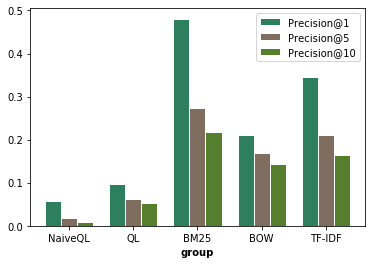

In [54]:
plt.bar(r6, precision1_1, color='#2d7f5e', width=barWidth, edgecolor='white', label='Precision@1')
plt.bar(r7, precision1_5, color='#7f6d5f', width=barWidth, edgecolor='white', label='Precision@5')
plt.bar(r8, precision1_10, color='#557f2d', width=barWidth, edgecolor='white', label='Precision@10')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + 1.5 for r in range(len(err1))], ['NaiveQL', 'QL', 'BM25', 'BOW', 'TF-IDF'])

plt.legend()
plt.show()

### Error

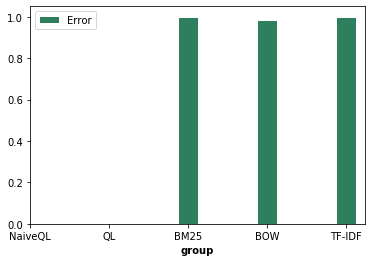

In [55]:
plt.bar(r2, err1, color='#2d7f5e', width=barWidth, edgecolor='white', label='Error')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(err1))], ['NaiveQL', 'QL', 'BM25', 'BOW', 'TF-IDF'])

plt.legend()
plt.show()

### MAP

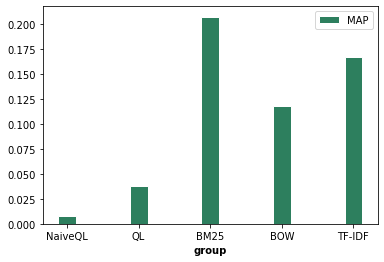

In [56]:
plt.bar(r2, map1, color='#2d7f5e', width=barWidth, edgecolor='white', label='MAP')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(err1))], ['NaiveQL', 'QL', 'BM25', 'BOW', 'TF-IDF'])

plt.legend()
plt.show()

Write a summary of what you observe in the results.
You summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.      
*Hint*: You may build upon the answers from the previous sections. 

Here we provide a summary of our results. We will first discuss the individual results for each algorithm and the differences that led to these results. Subsequently, we discuss the difference across the 2 indices.

First off, it has become clear that the naive implementation of Query Likelihood is outperformed by all the other methods. This seems to be the case because the naive assumption that documents that lack one of the words in the query get -infinity probability of being relevant. For longer queries this applies to almost every single document, essentially turning our method into gambling.

This is offset by the non-naive implementation of Query Likelihood which yields way better results, such as the mAP of 0.12 and 0.12 respectively for index 1 and 2. Replacing the value of negative infinity for documents lacking in one or more words in the query with a smoothing value causes our model not to punish lacking a single word too much. In return, we will still find relevant documents fairly quickly because we don't discard potentially relevant ones as soon anymore.

However, for us, BoW still seems to perform slightly better, albeit by a fairly small margin. This was still quite unexpected. Apparently, keeping track of which documents contain how many of the words in the query is still a valid method of ascertaining the relevance of documents. Intuitively, this makes sense because it is a very rudimentary yet very solid way of finding documents relevant to the query.

Fourthly, TF-IDF gets mAP scores of 0.17 and 0.25 on index 1 and 2 respectively. This is starting to look like something that works fairly well. TF-IDF achieves this improvement by also taking into account the weight of a word ('does it occur in every document or only in a few documents'), how often it occurs in the document and how long the document is. In doing so, we can discard meaningless words such as 'the' and only focus on the weighted fraction of the document that is covered by the query. This turns out to work fairly well because we are now finding documents that are very specific to our query.

Lastly, BM25 extends TF-IDF even further, resulting in the mAP scores of 0.21 and 0.26 on index 1 and 2 respectively. Apparently the adjustable weights allow for better weighing of the query than pure TF-IDF does. Moreover, these parameters also allow for even more manual fine-tuning.

Ultimately, across the 2 indices it becomes clear that index 2 outperforms index 1 every single time for each algorithm. This makes sense, because preprocessing the words is a very important part of the information retrieval pipeline. If an end-user searches with a query, e.g. inflections of the words are just as relevant as the specific words themselves. Preprocessing allows for better retrieval of these differences in inflection and other forms, in turn causing the metrics to rise in case we are using the preprocessed words of index 2 as opposed to the raw inputs of index 1.